When we model physical systems, we are trying to estimate a function $f:\chi\rightarrow\gamma$ by collecting evidence $\{x_i\in\chi,y_i\in\gamma\}$ to form an evidence set $\{\text{X}\subset\chi,\text{Y}\subset\gamma\}$.This evidence set $\{\text{X},\text{Y}\}$ limits possible hypotheses (functions) $h\in\mathcal{H},h:\chi\rightarrow\gamma$ to a subset $\text{H}\subset\mathcal{H}\text{ }|\text{ }\forall h\in\text{H}, h(x_i)=h(y_i)$. When the hypotheses $h\in\text{H}$ are consistent with some convergence criteria, we can make the claim that $h\sim f$. 

Exploring all of the input space $\chi$ is an expensive and/or impossible task, so we <it>need</it> to use a hypothesis $h$ to model $f$. However in most scientific settings, the collection of data $\{x_i,y_i\}$ is an expensive and/or time-consuming process in and of itself. Take, for example, the problem of predicting grain boundary mobilities from the 5-parameter grain boundary characteristic distribution. The calculation of a single grain boundary's mobility requires calling a <it>subroutine</it> which runs a molecular dynamics simulation. Thus it's important to pick the "most informative" $\{\text{X},\text{Y}\}$ that limits the cardinality of $\text{H}$. In other words, we need to limit the number of possible ways to "connect" points $\{x_i,y_i\}$ and $\{x_j,y_j\}$.

In [1]:
import matplotlib
matplotlib.use('svg')
%matplotlib inline
matplotlib.rcParams.update({'font.size': 23})

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

[]


In order to run this code, you need to have tensorflow, pandas, gpflow, and sci-kit learn. 

You can install gpflow with a simple "pip install gpflow". The GPflow docs are located at http://gpflow.readthedocs.io, but do note that all their docs use "import GPflow" while your setup will <it>probably</it> necessitate you use "import gpflow." There are other GP libraries (notably, GPy), but I've found GPflow to be the quickest to use (with GPU availability and the use of their "sparse" implementations).

In [2]:
import gpflow
import seaborn as sns
import itertools
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from gpflow.priors import LogNormal
import pandas as pd
import matplotlib.pyplot as plt

sns.set()

In [3]:
df = pd.read_csv("../fcc1-2.txt", delim_whitespace = True, skiprows = 6, header = None)

#Parse it into a readable column
X = pd.DataFrame(columns={0:'r1',1:'r2',2:'r3',3:'disorientation',4:'h1',5:'k1',6:'l1'})

X = pd.DataFrame(columns={0:'r1',1:'r2',2:'r3',3:'disorientation',4:'h1',5:'k1',6:'l1'})
i=0
while i < df.shape[0]:
    #print df.ix[i]
    if i==0:
        X =pd.DataFrame([df.ix[i][0],df.ix[i][1],df.ix[i][2],df.ix[i][4],df.ix[i][5],df.ix[i][6], df.ix[i][7]])
    else:
        X = pd.concat([X,pd.DataFrame([df.ix[i][0],df.ix[i][1],df.ix[i][2],df.ix[i][4],df.ix[i][5],df.ix[i][6], df.ix[i][7]])], axis=1)
    i=i+1
    try:
        while ~np.isnan(df.ix[i][6]):
            i=i+1
        while np.isnan(df.ix[i][6]):
            i=i+1
    except KeyError:
        continue

X = X.transpose().rename(columns={0:'r1',1:'r2',2:'r3',3:'disorientation',4:'h1',5:'k1',6:'l1'})

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


In [4]:
print(X.head())
GBChar = np.zeros((len(X),5)) #Five crystallographic degrees of freedom
GBChar[:,0:2] = X.values[:,0:2].astype('float32')
GBChar[:,2] = X.values[:,3].astype('float32')
GBChar[:,3] = X.values[:,4]/np.linalg.norm(X.values[:,4:7].astype('float32'),axis=-1)
GBChar[:,4] = X.values[:,5]/np.linalg.norm(X.values[:,4:7].astype('float32'),axis=-1)
print('')
print(GBChar.shape)

  r1 r2 r3 disorientation h1 k1 l1
0  1  0  0        36.8699  3  1  0
0  1  0  0        36.8699  2  0  0
0  1  1  0        70.5288  2  2  2
0  1  1  0        70.5288  2  1  1
0  1  1  0        70.5288  1  1  0

(388, 5)


In [5]:
Mobility = pd.read_csv("../fcc2-mobility.txt", delim_whitespace = True)
print(Mobility.head())
Mobility = Mobility.values[:,1]
print('')
print(Mobility.shape)

   GB_index  Mobility  (m/s-GPa)
0         1       121        NaN
1         2       106        NaN
2         3         0        NaN
3         4       210        NaN
4         5      1489        NaN

(388,)


In [6]:
Energy = np.sum(pd.read_csv('../GBE2.csv').values[:,14:17],axis=-1)
'''There are missing values. Im not sure which they are, so let's work with the Mobilities.'''
print(Energy.shape)

(382,)


In [7]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
shuffle_in_unison(GBChar,Mobility)
Mob = np.expand_dims(Mobility,axis=-1)

First, let's use a Gaussian Process to model the problem. Since our real distribution is an unbounded Uniform distribution, for the sake of simplicity, we're going to model the square root of the Mobility, and then get the actual Mobility values by squaring the predictions (assuring a positive result). 

In [8]:
kernel = gpflow.kernels.RBF(5)
m = gpflow.gpr.GPR(GBChar, Mob**0.5, kernel)
m.optimize()

      fun: 1266.1970469091266
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.33677272e-07,  -1.78698890e-08,  -2.22980689e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 29
      nit: 27
   status: 0
  success: True
        x: array([   7.38905228,  190.36003009,   31.74232674])

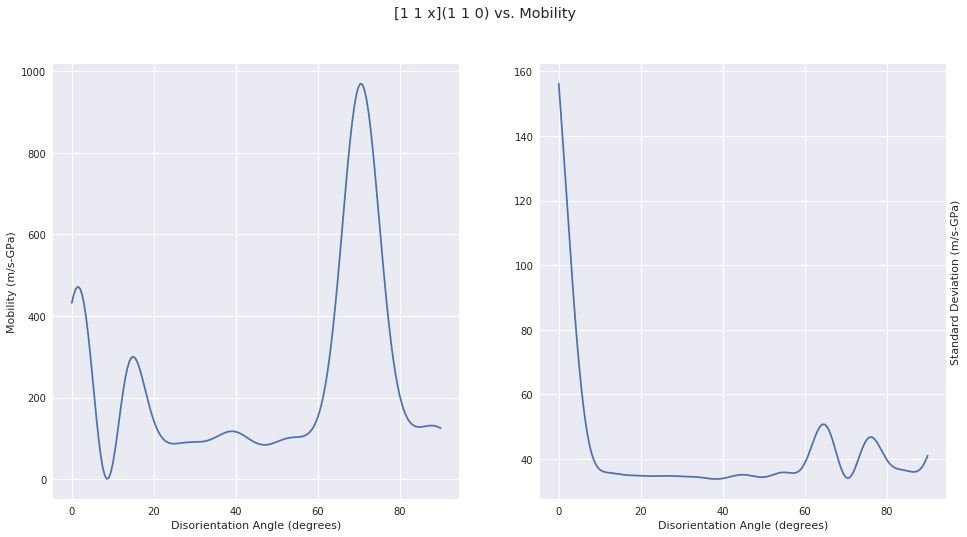

In [9]:
pX = np.expand_dims(np.linspace(0,90,180),axis=-1)
pX = np.concatenate((np.repeat([[1,1]],180,axis=0),pX),axis=-1)
pX = np.concatenate((pX,np.repeat([[1,0]],180,axis=0)/3),axis=-1)
pY, pYv = m.predict_y(pX)
fig = plt.figure(1,figsize=(16,8))
fig.suptitle('[1 1 x](1 1 0) vs. Mobility')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(pX[:,2],pY[:,0]**2)
ax2.plot(pX[:,2],pYv[:,0])
ax1.set_ylabel('Mobility (m/s-GPa)')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Standard Deviation (m/s-GPa)')

ax1.set_xlabel('Disorientation Angle (degrees)')
ax2.set_xlabel('Disorientation Angle (degrees)')

Now let's train a simple Random Forest regression model, and visualize the committee disagreement.

In [10]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(GBChar,Mob[:,0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

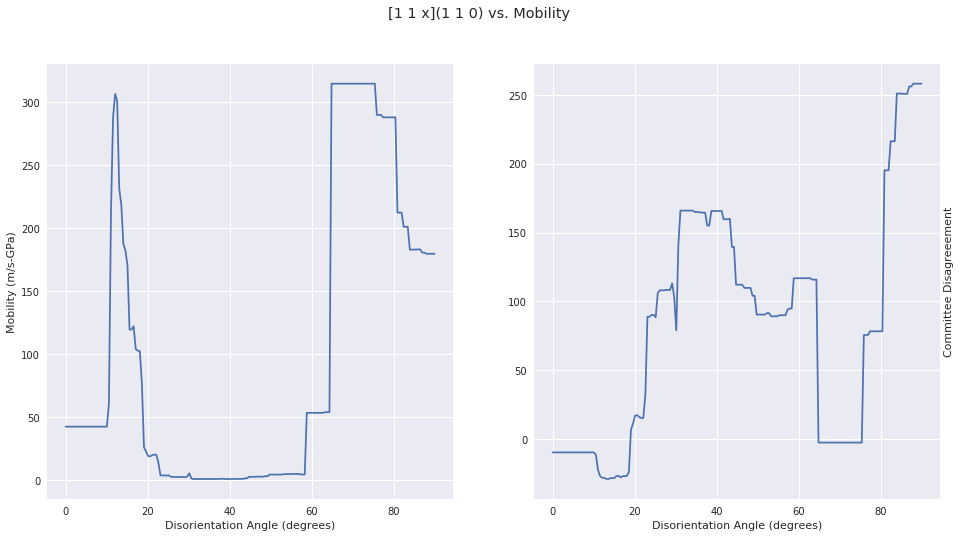

In [11]:
pX = np.expand_dims(np.linspace(0,90,180),axis=-1)
pX = np.concatenate((np.repeat([[1,1]],180,axis=0),pX),axis=-1)
pX = np.concatenate((pX,np.repeat([[1,0]],180,axis=0)/3),axis=-1)
pY = rf.predict(pX)
leafs = rf.apply(pX)
pYv = np.sum(leafs*np.log(leafs/np.repeat(np.expand_dims(pY,axis=-1),leafs.shape[-1],axis=1)),axis=-1)/leafs.shape[-1]
fig = plt.figure(2,figsize=(16,8))
fig.suptitle('[1 1 x](1 1 0) vs. Mobility')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(pX[:,2],pY)
ax2.plot(pX[:,2],pYv)
ax1.set_ylabel('Mobility (m/s-GPa)')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Committee Disagreeement')

ax1.set_xlabel('Disorientation Angle (degrees)')
ax2.set_xlabel('Disorientation Angle (degrees)')

Let's also use a simpler version of Ling et. al.'s uncertainty estimate.

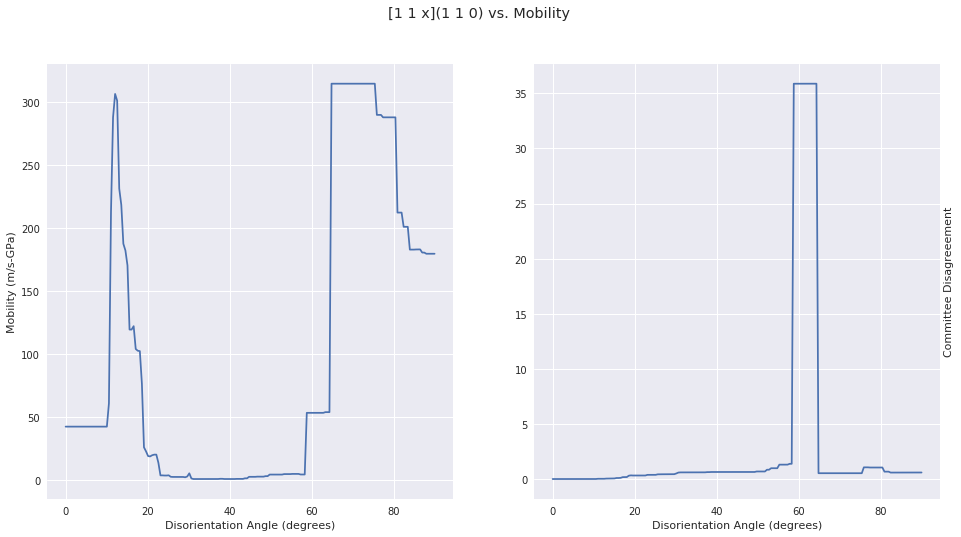

In [26]:
pX = np.expand_dims(np.linspace(0,90,180),axis=-1)
pX = np.concatenate((np.repeat([[1,1]],180,axis=0),pX),axis=-1)
pX = np.concatenate((pX,np.repeat([[1,0]],180,axis=0)/3),axis=-1)
pY = rf.predict(pX)
leafs = rf.apply(pX)
pYv = np.exp(1)*np.std(leafs,axis=-1)**2/leafs.shape[-1]
fig = plt.figure(2,figsize=(16,8))
fig.suptitle('[1 1 x](1 1 0) vs. Mobility')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(pX[:,2],pY)
ax2.plot(pX[:,2],pYv)
ax1.set_ylabel('Mobility (m/s-GPa)')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Committee Disagreeement')

ax1.set_xlabel('Disorientation Angle (degrees)')
ax2.set_xlabel('Disorientation Angle (degrees)')

Let's also look at committee disagreement in the GP model.

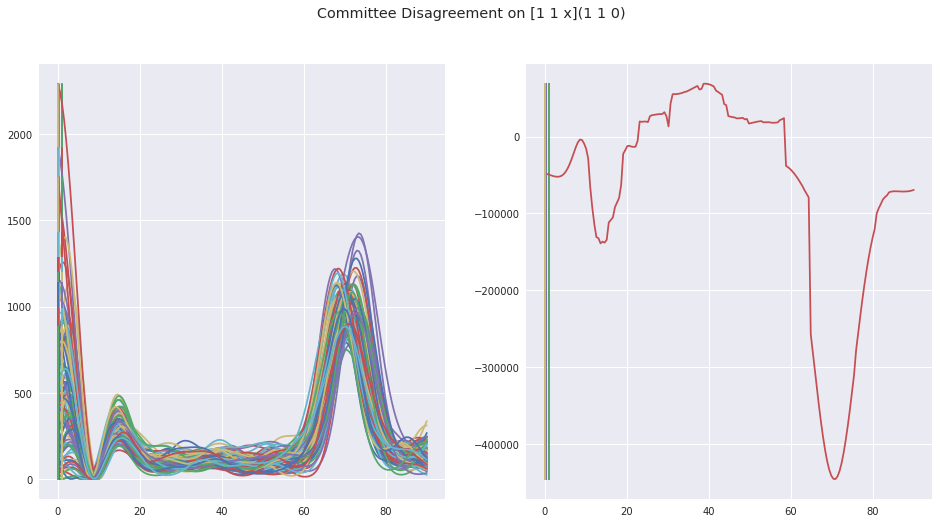

In [12]:
fig = plt.figure(1,figsize=(16,8))
fig.suptitle('Committee Disagreement on [1 1 x](1 1 0)')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

disagreement = np.zeros((pY.shape[0]))
for i in range(100):
    f = m.predict_f_samples(pX, 1) #construct committee
    ax1.plot(pX,f[0,:,0]**2)
    disagreement += (f[0,:,:].flatten()**2)*np.log((f[0,:,0]**2)/(pY.flatten()**2))

ax2.plot(pX,disagreement)

We can use this model as the basis for an active learning machine that calls the molecular statics subroutine (we can use this model to tell us where our knowledge of Grain Boundary Parameter space is most lacking). It seems that committee disagreement more intuitively works for our system, but let's draw a random pool and see what each method chooses. The random forest model (since it uses a completely independent ensemble) seems to have a better intuition as to what's missing, but the GP has a better model in general.

In [23]:
rand_dirs = np.random.randint(1,25,(1000,3))
rand_dirs = (rand_dirs/np.linalg.norm(rand_dirs,axis=0))[:,:-1]
rand_disori = np.random.uniform(0,90,(1000,1))
rand_planes = np.random.randint(1,25,(1000,3))
rand_planes = (rand_planes/np.linalg.norm(rand_planes,axis=0))[:,:-1]

rands = np.concatenate((rand_dirs,rand_disori,rand_planes),axis=-1)
pY = rf.predict(pX)
leafs = rf.apply(pX)
pYv = np.sum(leafs*np.log(leafs/np.repeat(np.expand_dims(pY,axis=-1),leafs.shape[-1],axis=1)),axis=-1)/leafs.shape[-1]
choice = rands[np.argmax(pYv)]
print('Random Forest:')
for val in choice:
    print(val)
print('')

print('Gaussian Process Uncertainty:')
rands = np.concatenate((rand_dirs,rand_disori,rand_planes),axis=-1)
pY, pYv = m.predict_y(rands)
choice = rands[np.argmax(pYv)]
for val in choice:
    print(val)
print('')
print('Gaussian Process Committee Disagreement:')
disagreement = np.zeros((pY.shape[0]))
for i in range(100):
    f = m.predict_f_samples(rands, 1) #construct committee
    disagreement += (f[0,:,0].flatten()**2)*np.log((f[0,:,0]**2)/(pY.flatten()**2))
choice = rands[np.argmax(disagreement)]
for val in choice:
    print(val)

Random Forest:
0.00889506266747
0.00449647151379
84.2377155081
0.0358563280425
0.0314357608406

Gaussian Process Uncertainty:
0.0066712970006
0.0247305933258
0.0456652985566
0.0336153075398
0.0157178804203

Gaussian Process Committee Disagreement:
0.0066712970006
0.0247305933258
0.0456652985566
0.0336153075398
0.0157178804203


Let's go with the Random Forest committee disagreement. It's quick, easy, and very informative.